In [222]:
import hytools as ht
import matplotlib.pyplot as plt
import numpy as np



In [223]:
import hytools as ht
import numpy as np

def get_spectral_data_and_wavelengths(filename, row_step, col_step):
    """
    Retrieve spectral data and wavelengths from a specified file using HyTools library.

    Parameters:
    - filename: str, the path to the file to be read.
    - row_step: int, the step size to sample rows by.
    - col_step: int, the step size to sample columns by.

    Returns:
    - original: np.ndarray, a 2D array where each row corresponds to the spectral data from one pixel.
    - wavelengths: np.ndarray, an array containing the wavelengths corresponding to each spectral band.
    """
    # Initialize the HyTools object
    envi = ht.HyTools()
    
    # Read the file using the specified format
    envi.read_file(filename, 'envi')
    
    # Define the row and column ranges
    rowrange = np.arange(0, round(envi.lines, -3), row_step).tolist()  # Adjusted to use envi.lines for dynamic range
    colrange = np.arange(0, round(envi.columns, -3), col_step).tolist()  # Adjusted to use envi.columns for dynamic range
    
    # Retrieve the pixels' spectral data
    original = envi.get_pixels(rowrange, colrange)
    
    # Also retrieve the wavelengths
    wavelengths = envi.wavelengths
    
    return original, wavelengths


In [287]:
filenames = [
    "export/resample_landsat5",
    "export/resample_landsat7",
    "export/resample_landsat8",
    "export/resample_landsat9.img",
    "export/ENVI__corrected_0",
    "export/ENVI__corrected_0_mask"
]

# Initialize dictionary to store results
results = {}

row_step, col_step = 6, 1  # Define your steps here

# Loop through filenames
for filename in filenames:
    spectral_data, wavelengths = get_spectral_data_and_wavelengths(filename, row_step, col_step)
    results[filename] = {"spectral_data": spectral_data, "wavelengths": wavelengths}

# Now, results contain spectral data and wavelengths for each file
results

{'export/resample_landsat5': {'spectral_data': array([[-9998.99999782, -9999.        , -9999.        , -9999.        ,
          -9999.        , -9998.83389576],
         [-9998.99999782, -9999.        , -9999.        , -9999.        ,
          -9999.        , -9998.83389576],
         [-9998.99999782, -9999.        , -9999.        , -9999.        ,
          -9999.        , -9998.83389576],
         ...,
         [-9998.99999782, -9999.        , -9999.        , -9999.        ,
          -9999.        , -9998.83389576],
         [-9998.99999782, -9999.        , -9999.        , -9999.        ,
          -9999.        , -9998.83389576],
         [-9998.99999782, -9999.        , -9999.        , -9999.        ,
          -9999.        , -9998.83389576]]),
  'wavelengths': array([ 485.,  560.,  660.,  830., 1650., 2215.])},
 'export/resample_landsat7': {'spectral_data': array([[-9999., -9999., -9999., -9999., -9999., -9999.],
         [-9999., -9999., -9999., -9999., -9999., -9999.],
     

In [294]:
first_key

'export/ENVI__corrected_0'

In [288]:
import pandas as pd
import numpy as np

def access_or_prepare_data(results, index):
    keys = list(results.keys())
    if index < 0 or index >= len(keys):
        print("Index out of range")
        return None

    first_key = keys[index]
    spectral_data = results[first_key]['spectral_data']
    wavelengths = results[first_key]['wavelengths']

    
    if index < 4:
        # Create a DataFrame from the spectral data
        df_spectral_data = pd.DataFrame(spectral_data, columns=wavelengths.astype(str))

        # Now 'df_spectral_data' is a pandas DataFrame with each column named after its corresponding wavelength
        #df_spectral_data

        long_df = pd.melt(pd.DataFrame(df_spectral_data), var_name="wavelength_nm", value_name="reflectance")
        #long_df

        waves = pd.DataFrame(wavelengths, columns=["wavelength_nm"])
        waves['band'] = range(len(waves))
        #waves

    
        # Convert 'wavelength_nm' to numeric, if necessary
        long_df["wavelength_nm"] = pd.to_numeric(long_df["wavelength_nm"])
        merged_data = pd.merge(long_df, waves, on='wavelength_nm')
    
        return merged_data
    
    else:
        # Prepare the data using the custom function
        return prepare_spectral_data(spectral_data, wavelengths)

def prepare_spectral_data(spectral_data, wavelengths):
    long_df = pd.melt(pd.DataFrame(spectral_data).transpose(), var_name="band", value_name="reflectance")
    waves = pd.DataFrame(wavelengths, columns=["wavelength_nm"])
    waves['band'] = range(len(waves))
    merged_data = pd.merge(long_df, waves, on='band')
    merged_data["wavelength_nm"] = pd.to_numeric(merged_data["wavelength_nm"])
    return merged_data

# Example usage with 'results' dictionary populated as shown in previous examples
index = 4  # Example index
data = access_or_prepare_data(results, index)

if data is not None:
    if isinstance(data, tuple):
        spectral_data, wavelengths = data
        # Process the spectral data and wavelengths as needed
    else:
        prepared_data = data
        # Process the prepared data as needed


In [314]:
def access_or_prepare_data(results, index):
    keys = list(results.keys())
    if index < 0 or index >= len(keys):
        print("Index out of range")
        return None

    first_key = keys[index]
    spectral_data = results[first_key]['spectral_data']
    wavelengths = results[first_key]['wavelengths']

    if index < 4:
        df_spectral_data = pd.DataFrame(spectral_data, columns=wavelengths.astype(str))
        long_df = pd.melt(df_spectral_data, var_name="wavelength_nm", value_name="reflectance")
        waves = pd.DataFrame(wavelengths, columns=["wavelength_nm"])
        waves['band'] = range(len(waves))
        long_df["wavelength_nm"] = pd.to_numeric(long_df["wavelength_nm"])
        merged_data = pd.merge(long_df, waves, on='wavelength_nm')
        # Add a label column to the merged data
        first_key = keys[index].replace("export/resample_", "")  # Modified here to remove "export/"
        merged_data['sensor'] = first_key
        merged_data = merged_data.reindex(columns=['sensor', 'band', 'wavelength_nm', 'reflectance'])
        return merged_data
    else:
        merged_data = prepare_spectral_data(spectral_data, wavelengths)
        # Add a label column to the merged data
        first_key = keys[index].replace("export/", "")  # Modified here to remove "export/"
        merged_data['sensor'] = first_key
        merged_data = merged_data.reindex(columns=['sensor', 'band', 'wavelength_nm', 'reflectance'])
        return merged_data


In [316]:
# Replace 'results' with your actual dictionary variable
prepared_or_accessed_data = access_or_prepare_data(results, 0)

# Now, 'prepared_or_accessed_data' contains the data you need
prepared_or_accessed_data

,sensor,band,wavelength_nm,reflectance
0,landsat5,0,485.0,-9998.999998
1,landsat5,0,485.0,-9998.999998
2,landsat5,0,485.0,-9998.999998
3,landsat5,0,485.0,-9998.999998
4,landsat5,0,485.0,-9998.999998
...,...,...,...,...
5995,landsat5,5,2215.0,-9998.833896
5996,landsat5,5,2215.0,-9998.833896
5997,landsat5,5,2215.0,-9998.833896
5998,landsat5,5,2215.0,-9998.833896


In [271]:
import pandas as pd
import numpy as np

# Assuming 'results' is your dictionary
first_key = list(results.keys())[3]  # Get the first key from the dictionary
spectral_data = results[first_key]['spectral_data']  # Access the spectral_data array for this key
wavelengths = results[first_key]['wavelengths']  # Access the wavelengths array for this key

# Create a DataFrame from the spectral data
df_spectral_data = pd.DataFrame(spectral_data, columns=wavelengths.astype(str))

# Now 'df_spectral_data' is a pandas DataFrame with each column named after its corresponding wavelength
#df_spectral_data

long_df = pd.melt(pd.DataFrame(df_spectral_data), var_name="wavelength_nm", value_name="reflectance")
#long_df

waves = pd.DataFrame(wavelengths, columns=["wavelength_nm"])
waves['band'] = range(len(waves))
waves

    
    # Convert 'wavelength_nm' to numeric, if necessary
long_df["wavelength_nm"] = pd.to_numeric(long_df["wavelength_nm"])
merged_data = pd.merge(long_df, waves, on='wavelength_nm')
    
merged_data




,wavelength_nm,reflectance,band
0,453.0,-9999.000000,0
1,453.0,-9999.000000,0
2,453.0,-9999.000000,0
3,453.0,-9999.000000,0
4,453.0,-9999.000000,0
...,...,...,...
5995,2200.0,-9998.999351,5
5996,2200.0,-9998.999351,5
5997,2200.0,-9998.999351,5
5998,2200.0,-9998.999351,5


In [272]:
import pandas as pd

def prepare_spectral_data(spectral_data, wavelengths):
    # Transpose and melt the spectral data to long format
    long_df = pd.melt(pd.DataFrame(spectral_data).transpose(), var_name="band", value_name="reflectance")
    
    # Create a DataFrame for wavelengths and assign a 'band' column based on index
    waves = pd.DataFrame(wavelengths, columns=["wavelength_nm"])
    waves['band'] = range(len(waves))
    
    # Merge the spectral data with wavelengths using the 'band' column
    merged_data = pd.merge(long_df, waves, on='band')
    
    # Convert 'wavelength_nm' to numeric, if necessary
    merged_data["wavelength_nm"] = pd.to_numeric(merged_data["wavelength_nm"])
    
    return merged_data

# Example usage
#spectral_data_corrected = np.random.rand(10, 426)  # Example spectral data
#full_wavelengths = np.linspace(400, 2500, 426)  # Example wavelength range
# Assuming 'results' is your dictionary
first_key = list(results.keys())[4]  # Get the first key from the dictionary
spectral_data = results[first_key]['spectral_data']  # Access the spectral_data array for this key
wavelengths = results[first_key]['wavelengths']  # Access the wavelengths array for this key


prepared_data = prepare_spectral_data(spectral_data, wavelengths)
pd.DataFrame(prepared_data)



,band,reflectance,wavelength_nm
0,0,-9999.0,381.273010
1,0,-9999.0,381.273010
2,0,-9999.0,381.273010
3,0,-9999.0,381.273010
4,0,-9999.0,381.273010
...,...,...,...
425995,425,-9999.0,2509.728027
425996,425,-9999.0,2509.728027
425997,425,-9999.0,2509.728027
425998,425,-9999.0,2509.728027


In [206]:
def process_all_datasets(results):
    processed_data = {}
    for filename, data in results.items():
        spectral_data = data['spectral_data']
        wavelengths = data['wavelengths']
        prepared_data = prepare_spectral_data(spectral_data, wavelengths)
        processed_data[filename] = prepared_data
    return processed_data

# Assuming 'results' is your dictionary with spectral data and wavelengths
processed_datasets = process_all_datasets(results)
processed_datasets

{'export/resample_landsat5':     band  reflectance  wavelength_nm
 0      0 -9998.999998          485.0
 1      0 -9999.000000          485.0
 2      0 -9999.000000          485.0
 3      0 -9999.000000          485.0
 4      0 -9999.000000          485.0
 5      0 -9998.833896          485.0
 6      1 -9998.999998          560.0
 7      1 -9999.000000          560.0
 8      1 -9999.000000          560.0
 9      1 -9999.000000          560.0
 10     1 -9999.000000          560.0
 11     1 -9998.833896          560.0
 12     2 -9998.999998          660.0
 13     2 -9999.000000          660.0
 14     2 -9999.000000          660.0
 15     2 -9999.000000          660.0
 16     2 -9999.000000          660.0
 17     2 -9998.833896          660.0
 18     3 -9998.999998          830.0
 19     3 -9999.000000          830.0
 20     3 -9999.000000          830.0
 21     3 -9999.000000          830.0
 22     3 -9999.000000          830.0
 23     3 -9998.833896          830.0
 24     4 -9998.999998

In [202]:
import pandas as pd
pd.DataFrame(results)

,export/resample_landsat5,export/resample_landsat7,export/resample_landsat8,export/resample_landsat9.img,export/ENVI__corrected_0
spectral_data,"[[-9998.999997820287, -9998.999999999909, -999...","[[-9999.0, -9999.000000000002, -9999.0, -9999....","[[-9998.999999993024, -9999.000000000004, -999...","[[-9999.0, -9999.0, -9999.0, -9999.0, -9999.0,...","[[-9999.0, -9999.0, -9999.0, -9999.0, -9999.0,..."
wavelengths,"[485.0, 560.0, 660.0, 830.0, 1650.0, 2215.0]","[477.0, 560.0, 662.0, 835.0, 1648.0, 2206.0]","[480.0, 560.0, 655.0, 865.0, 1610.0, 2200.0]","[453.0, 560.0, 655.0, 865.0, 1610.0, 2200.0]","[381.27301, 386.281097, 391.289215, 396.297302..."


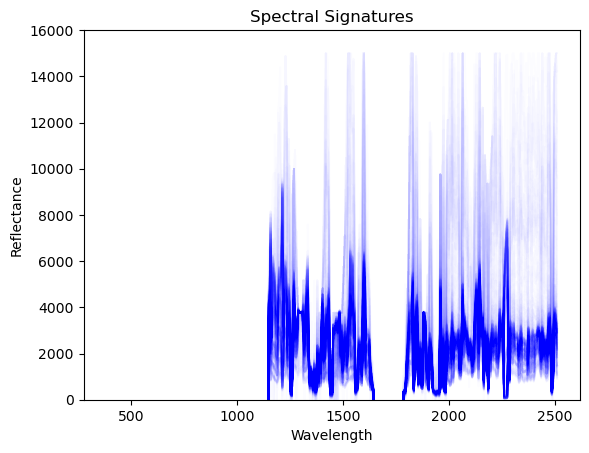

In [233]:
import matplotlib.pyplot as plt

def plot_spectral_signatures(wavelengths, spectral_data, line_color='blue', transparency=0.5):
    """
    Plot spectral signatures for each pixel in the spectral data, all in the same specified color and with transparency.

    Parameters:
    - wavelengths: array-like, the wavelengths corresponding to the spectral bands.
    - spectral_data: 2D array, spectral data where each row corresponds to a pixel and columns to spectral bands.
    - line_color: str, optional, the color of the lines. Default is 'blue'.
    - transparency: float, optional, the transparency level of the lines. Default is 0.5.
    """
    # Check if spectral_data is not empty
    if spectral_data.size == 0:
        print("Spectral data is empty.")
        return

    num_wavelengths = len(wavelengths)  # Dynamically get the number of wavelengths
    
    # Plotting each pixel's spectral signature
    for i in range(spectral_data.shape[0]):  # Loop through each row/pixel
        # Ensure plotting only up to the number of available wavelengths
        plt.plot(wavelengths, spectral_data[i, :num_wavelengths], color=line_color, alpha=transparency)
    
    plt.xlabel('Wavelength')
    plt.ylabel('Reflectance')
    plt.title('Spectral Signatures')
    plt.ylim(0, 16000)
    plt.show()

# Example usage:
# Assuming envi.wavelengths and spectral_data are already defined:
plot_spectral_signatures(wavelengths_full, spectral_data_corrected, 'blue', 0.01)
plot_spectral_signatures(wavelengths_full, spectral_data_corrected, 'blue', 0.01)



In [77]:
import pandas as pd
pd.DataFrame(spectral_data_corrected).transpose() 

,0,1,2,3,4,5,6,7,8,9,...,416,417,418,419,420,421,422,423,424,425
0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,...,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0
1,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,...,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0
2,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,...,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0
3,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,...,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0
4,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,...,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,...,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0
996,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,...,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0
997,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,...,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0
998,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,...,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0


In [181]:
import pandas as pd
import numpy as np

# Assuming `before_df` is your initial DataFrame and you need to perform similar operations:
#sampled_df = before_df.sample(n=50000)
long_df = pd.melt(pd.DataFrame(spectral_data_corrected).transpose() , var_name="band", value_name="reflectance")
#long_df['band'] = pd.to_numeric(long_df['wavelength_nm'])
long_df

,band,reflectance
0,0,-9999.0
1,0,-9999.0
2,0,-9999.0
3,0,-9999.0
4,0,-9999.0
...,...,...
425995,425,-9999.0
425996,425,-9999.0
425997,425,-9999.0
425998,425,-9999.0


In [182]:
waves=pd.DataFrame(full_wavelengths)
waves['band'] = range(len(waves))
waves.columns.values[0] = "wavelength_nm"
waves


,wavelength_nm,band
0,381.273010,0
1,386.281097,1
2,391.289215,2
3,396.297302,3
4,401.305511,4
...,...,...
421,2489.695557,421
422,2494.703613,422
423,2499.711914,423
424,2504.719971,424


In [183]:
full_dataset

,wavelength_nm,reflectance,band
0,381.273010,NaN,0
1,386.281097,NaN,1
2,391.289215,NaN,2
3,396.297302,NaN,3
4,401.305511,NaN,4
...,...,...,...
421,2489.695557,NaN,421
422,2494.703613,NaN,422
423,2499.711914,NaN,423
424,2504.719971,NaN,424


In [175]:
full_dataset =long_df.merge(waves, how='right', on='wavelength_nm')
full_dataset["wavelength_nm"] = pd.to_numeric(full_dataset["wavelength_nm"])

#full_dataset = full_dataset.drop('band', axis=1)
full_dataset

,wavelength_nm,reflectance,band
0,381.273010,NaN,0
1,386.281097,NaN,1
2,391.289215,NaN,2
3,396.297302,NaN,3
4,401.305511,NaN,4
...,...,...,...
421,2489.695557,NaN,421
422,2494.703613,NaN,422
423,2499.711914,NaN,423
424,2504.719971,NaN,424


In [185]:

merged_data = pd.merge(long_df, waves, on='band')


In [186]:
merged_data

,band,reflectance,wavelength_nm
0,0,-9999.0,381.273010
1,0,-9999.0,381.273010
2,0,-9999.0,381.273010
3,0,-9999.0,381.273010
4,0,-9999.0,381.273010
...,...,...,...
425995,425,-9999.0,2509.728027
425996,425,-9999.0,2509.728027
425997,425,-9999.0,2509.728027
425998,425,-9999.0,2509.728027


        band  reflectance  wavelength_nm
0          0      -9999.0     381.273010
1          0      -9999.0     381.273010
2          0      -9999.0     381.273010
3          0      -9999.0     381.273010
4          0      -9999.0     381.273010
...      ...          ...            ...
425995   425      -9999.0    2509.728027
425996   425      -9999.0    2509.728027
425997   425      -9999.0    2509.728027
425998   425      -9999.0    2509.728027
425999   425      -9999.0    2509.728027

[426000 rows x 3 columns]


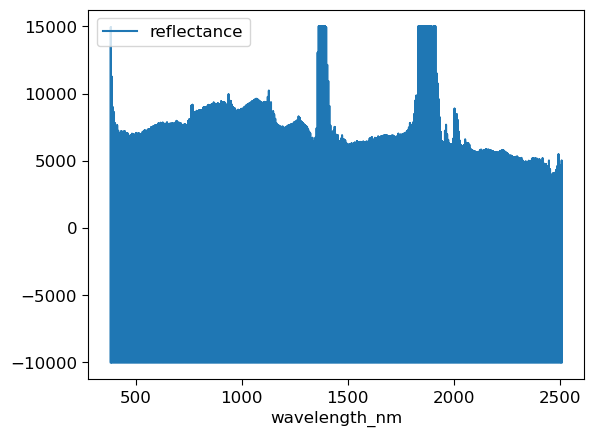

In [193]:
import matplotlib.pyplot as plt
ax =prepared_data.plot( x = 'wavelength_nm', y = 'reflectance',  use_index=True)

plt.show()

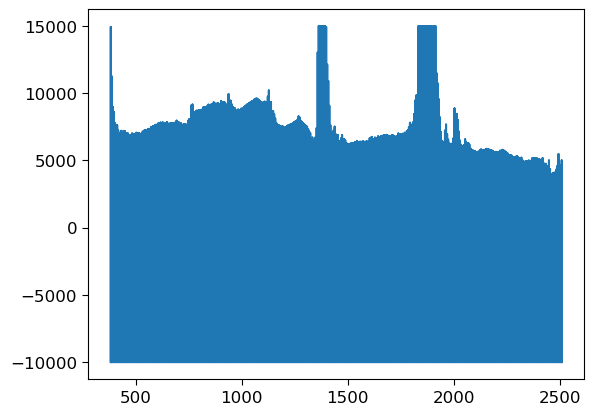

In [188]:
plt.plot(merged_data.wavelength_nm, merged_data.reflectanceplot)
